In [1]:
import osgeo
import os
from os.path import join as pjoin
import rioxarray
import xarray as xr
import numpy as np
#import matplotlib as plt
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from rasterio import features
import pandas as pd
import rasterio

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import r2_score,mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


scratch_dir = './data' 

In [2]:
aoi = gpd.read_file("data/Train/classifications/Classifications.shp")
aoi = aoi[['layer', 'is_glacier', 'geometry']]
# aoi.is_glacier = aoi.is_glacier.astype(str)
aoi['is_glacier'].loc[aoi['is_glacier']==0] = 2
print (aoi.tail())

                layer  is_glacier  \
80  Rivier Dnudh Kosi           2   
81               Rots           2   
82               Rots           2   
83               Rots           2   
84               Rots           2   

                                             geometry  
80  POLYGON ((86.71343 27.72815, 86.71342 27.72814...  
81  POLYGON ((86.82155 28.19028, 86.82148 28.19008...  
82  POLYGON ((86.86028 28.14301, 86.85935 28.14468...  
83  POLYGON ((87.33841 28.14561, 87.33048 28.14714...  
84  POLYGON ((86.47362 28.13161, 86.47442 28.13208...  


In [3]:
file_location = 'data/train_data_resampledNDWI.tif'
d = rioxarray.open_rasterio(file_location).squeeze() 
d.coords['band'] = d.coords['band'] +2008
d  # Show data information

<xarray.DataArray (y: 4862, x: 3159)>
[15359058 values with dtype=float64]
Coordinates:
    band         int32 2009
  * x            (x) float64 86.44 86.44 86.44 86.44 ... 87.42 87.42 87.42 87.42
  * y            (y) float64 28.2 28.2 28.2 28.19 ... 26.87 26.87 26.87 26.87
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     stackstac-9a6396e2000585f4bd4bc8177697ba83

In [4]:
# We also prepare the color codes for visualization
colors = [(257, 71, 27), (98, 93, 78)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=4)
    for rgb in pal[1:]:
        cols.append(rgb)
# Assign color codes to LULC types 
symbology = {'Glacier': cols[2],
             'Non Glacier': cols[0]}

In [5]:
# Labels from the AOIs
aoi['aoi_cat'] = pd.Categorical(aoi['is_glacier'])

# Rasterize
rst = rasterio.open('data/train_data_resampledNDWI.tif')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'data/train/aoi_rasterizedNDWI.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

stack = np.array([])

print(d.shape)  # Each time, also check the size of the image
    
# In order to do clustering, image should be reshaped into a single column
band_col = d.values.reshape(-1, 1)
   
# Each time put the reshaped image into the stack
stack = np.hstack((stack, band_col)) if stack.size else band_col
# Also to check the size of the stack
print(stack.shape)

(4862, 3159)
(15359058, 1)


In [6]:
aoi2 = gpd.read_file("data/Val/classifications/valclass1999.shp")
aoi2 = aoi2[['layer', 'is_glacier', 'geometry']]
# aoi.is_glacier = aoi.is_glacier.astype(str)
aoi2['is_glacier'].loc[aoi2['is_glacier']==0] = 2
print (aoi2.tail())

file_location2 = 'data/validation_data_resampledNDWI.tif'
d2 = rioxarray.open_rasterio(file_location2).squeeze() 
d2.coords['band'] = d2.coords['band'] +1998

# Labels from the AOIs
aoi2['aoi_cat'] = pd.Categorical(aoi2['is_glacier'])

# Rasterize
rst2 = rasterio.open('data/validation_data_resampledNDWI.tif')  # Base image to rasterize the *.shp
meta = rst2.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'data/val/aoi_rasterizedNDWI.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

stack2 = np.array([])

print(d2.shape)  # Each time, also check the size of the image
    
# In order to do clustering, image should be reshaped into a single column
band_col2 = d2.values.reshape(-1, 1)
   
# Each time put the reshaped image into the stack
stack2 = np.hstack((stack2, band_col2)) if stack2.size else band_col2
# Also to check the size of the stack
print(stack2.shape)

    layer  is_glacier                                           geometry
118   NaN           2  POLYGON Z ((86.47362 28.13161 0.00000, 86.4744...
119   NaN           2  POLYGON Z ((87.34172 28.19500 0.00000, 87.3419...
120   NaN           2  POLYGON Z ((87.30722 28.12600 0.00000, 87.3075...
121   NaN           2  POLYGON Z ((87.30358 28.16715 0.00000, 87.3037...
122   NaN           2  POLYGON Z ((86.99124 28.19371 0.00000, 86.9913...
(4860, 3159)
(15352740, 1)


In [7]:
# Load the rasterized LULC types in the AOI and concatenate it together with the images

aoi_rst = rasterio.open('data/train/aoi_rasterizedNDWI.tif').read(1)
aoi_rst2 = rasterio.open('data/val/aoi_rasterizedNDWI.tif').read(1)

# Stack the label with the input bands
data = np.c_[stack, aoi_rst.reshape(-1,)]
data2 = np.c_[stack2, aoi_rst2.reshape(-1,)]

# Of course, we are only interested in pixels with LULC type labelled
data = data[np.where(data[:,data.shape[1]-1]!=0)]
data2 = data2[np.where(data2[:,data2.shape[1]-1]!=0)]


X_train = data[:, :1] 
Y_train = data[:, 1:].reshape(-1,) 

X_test = data2[:, :1] 
Y_test = data2[:, 1:].reshape(-1,)  


In [8]:
aoi['is_glacier'].loc[aoi['is_glacier'] == 1] = 'Glacier'
aoi['is_glacier'].loc[aoi['is_glacier'] == 2] = 'Non Glacier'
aoi2['is_glacier'].loc[aoi2['is_glacier'] == 1] = 'Glacier'
aoi2['is_glacier'].loc[aoi2['is_glacier'] == 2] = 'Non Glacier'

C:\Users\Jurrian\AppData\Local\Temp\ipykernel_13092\3801277370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi['is_glacier'].loc[aoi['is_glacier'] == 1] = 'Glacier'
C:\Users\Jurrian\AppData\Local\Temp\ipykernel_13092\3801277370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi2['is_glacier'].loc[aoi2['is_glacier'] == 1] = 'Glacier'


In [9]:
# Create a decision tree object
dt = DecisionTreeClassifier()

# Define the hyperparameter grid
param_grid = {'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'min_samples_split': [2,3, 4,5, 6, 8, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


[Text(0.5, 0.8333333333333334, 'x[0] <= -0.045\ngini = 0.356\nsamples = 328722\nvalue = [252691, 76031]'),
 Text(0.25, 0.5, 'x[0] <= -0.113\ngini = 0.202\nsamples = 66810\nvalue = [7595, 59215]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.046\nsamples = 42452\nvalue = [994, 41458]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.395\nsamples = 24358\nvalue = [6601, 17757]'),
 Text(0.75, 0.5, 'x[0] <= -0.033\ngini = 0.12\nsamples = 261912\nvalue = [245096, 16816]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.411\nsamples = 10631\nvalue = [7557, 3074]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.103\nsamples = 251281\nvalue = [237539, 13742]')]

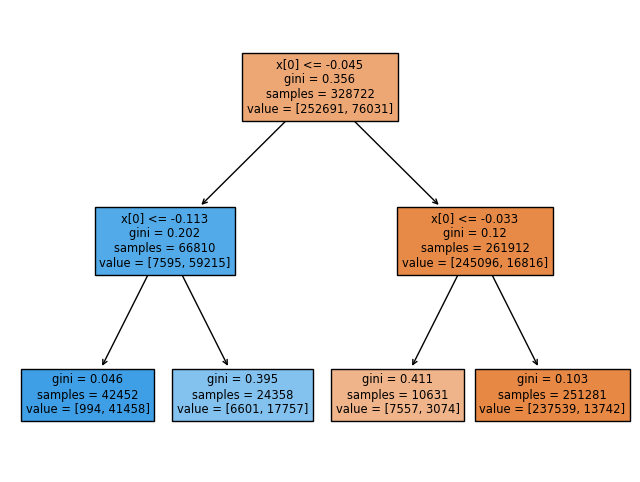

In [10]:
# Initiate a tree model
tree_depth = grid_search.best_params_['max_depth'] #dit is 2 voor het geval je het bovenstaande niet wilt runnen
min_sample_split= grid_search.best_params_['min_samples_split'] #dit is 2
min_samples_leaf= grid_search.best_params_['min_samples_leaf'] # dit is 1
model_tree = DecisionTreeClassifier(max_depth=tree_depth, min_samples_split=min_sample_split, min_samples_leaf=min_samples_leaf)

# Fit the model to your data.
# Please note that the output of this fitting is a model with several parameters that are configurable, so far you only configured "max_depth" while training/fitting.
model_tree.fit(X_train, Y_train)

# Visualize split
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))
tree.plot_tree(model_tree, filled=True)

In [11]:
Y_pred = pd.Series(list(model_tree.predict(X_test[:,0].reshape(-1,1))), name='DT prediction')  # Store the predicted value in Y_pred
Y_actu = pd.Series(list(Y_test), name='Manual delineation')

# Map the LULC codes to the actual name of LULC types

# First we need a mapping from the LULC codes to the actual LULC type name.
code_lulc = { 1: 'Glacier',
              2: 'Non Glacier'}

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
Y_actu2 = Y_actu.replace(code_lulc)
Y_pred2 = Y_pred.replace(code_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(Y_actu2, Y_pred2)
df_confusion2

DT prediction,Glacier,Non Glacier
Manual delineation,,
Glacier,251940,659
Non Glacier,35430,40534


In [12]:
# Print out more detailed accuracy assessment report

from sklearn.metrics import classification_report

print(classification_report(Y_actu2, Y_pred2))

              precision    recall  f1-score   support

     Glacier       0.88      1.00      0.93    252599
 Non Glacier       0.98      0.53      0.69     75964

    accuracy                           0.89    328563
   macro avg       0.93      0.77      0.81    328563
weighted avg       0.90      0.89      0.88    328563



In [13]:
Y_pred_all = model_tree.predict(stack2)

c:\Users\Jurrian\anaconda3\envs\ssml\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Printing large image takes time...


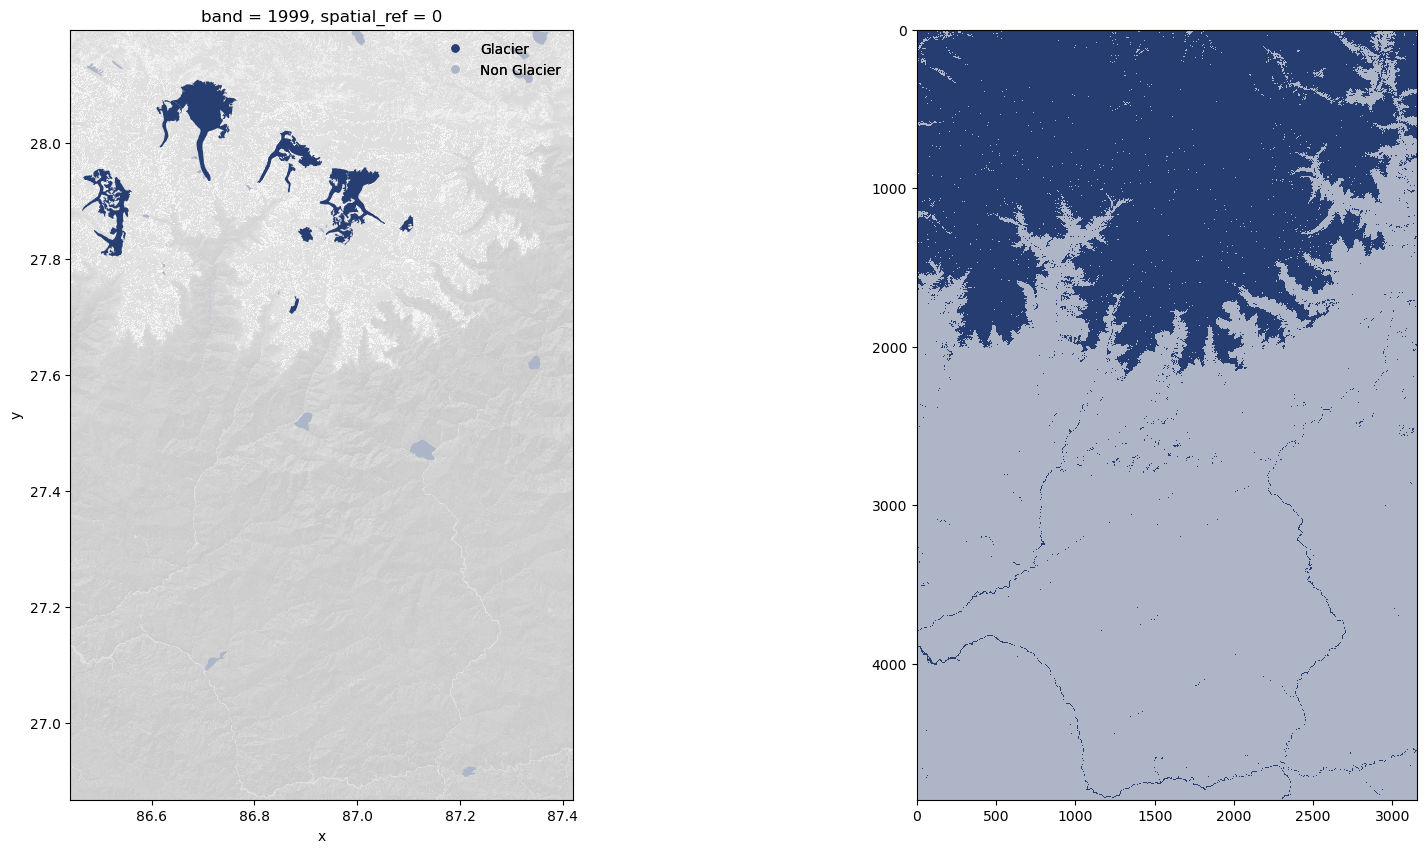

In [14]:
# Visualize
fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
d2.plot(ax=ax1, cmap='gray', alpha=0.25, add_colorbar=False)  # Plot the satellite image
aoi2.plot(ax=ax1, column='land_cover', legend=True, color=aoi2['is_glacier'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax1.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax1.add_artist(leg_points)

# Assign color codes to LULC types 
symbology2 = {1: cols[2],
              2: cols[0]}

from matplotlib.colors import ListedColormap
cm = ListedColormap(symbology2.values())
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

# Visualize
# Because the predicted labels are still in one column, you need to reshape it back to original image shape
row, col = d2.shape  # Get the original dimensions of the image
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

print('Printing large image takes time...')
ax2.imshow(Y_pred_all.reshape(row, col), cmap=cm, interpolation='none', vmin=imin, vmax=imax)

In [15]:
file_location3 = 'data/resampledNDWI.tif'
data_all = rioxarray.open_rasterio(file_location3).squeeze() 
data_all.coords['band'] = data_all.coords['band'] +1991
print(data_all.shape)
data_all = data_all.dropna(dim = 'band', how = 'all')
data_all = data_all.notnull()


stack_all = np.array([])

print(data_all.shape)  # Each time, also check the size of the image
    
# In order to do clustering, image should be reshaped into a single column
band_col_all = data_all.values.reshape(-1, 1)
   
# Each time put the reshaped image into the stack
stack_all = np.hstack((stack_all, band_col_all)) if stack_all.size else band_col_all
# Also to check the size of the stack
print(stack_all.shape)

(31, 4865, 3160)
(11, 4865, 3160)
(169107400, 1)


In [16]:
print(stack_all.shape)
np.isnan(stack_all).sum()

(169107400, 1)


0

In [17]:
Y_pred_all = model_tree.predict(stack_all)

In [18]:
results = xr.DataArray(Y_pred_all.reshape(data_all.shape),
                       coords ={'time':data_all.coords['band'], 
                                'y': data_all.coords['y'], 
                                'x': data_all.coords['x']}, 
                                dims=['band', 'y', 'x'])
results.rio.to_raster(pjoin(scratch_dir, 'resultsNDWI.tif'), compress='LZW')